In [4]:
#Imports

# base
import numpy as np
import pandas as pd
from scipy import stats

# keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


Notes: Next steps include omission of variables in the soundfiles. Need to analyse the channels in the soundfile. Standardscaler for images seem to not do anything sensible. 

Current best results range between 99.08% - 99.18% accuracy. Baseline (when every prediction is set to false) is around 90%. 

# 1.1 Load Data

In [72]:
#load datafiles
written_train_input = np.load("written_train.npy", allow_pickle=True)
spoken_train_input = np.load("spoken_train.npy", allow_pickle=True)
match_train_input = np.load("match_train.npy", allow_pickle=True)

# 1.2 Data Exploration

In [73]:
print('written_train_input:', written_train_input.shape)
print(written_train_input[0])
print()
print('spoken_train_input:', spoken_train_input.shape)
print(spoken_train_input[0])
print()
print('match_train_input:', match_train_input.shape)
print(match_train_input[0])

written_train_input: (45000, 784)
[255 254 254 255 254 253 255 254 255 255 255 255 255 254 251 254 255 255
 255 255 253 255 255 255 255 255 255 255 255 255 254 255 255 255 253 255
 255 253 254 255 255 255 255 255 255 255 252 255 253 254 250 254 255 250
 255 255 255 253 255 255 255 255 252 255 251 255 255 255 255 253 255 255
 251 254 255 254 255 255 250 255 254 255 255 255 253 254 255 254 254 254
 255 253 255 255 255 249 255 255 255 255 254 255 254 254 255 255 254 253
 254 253 255 255 255 252 255 255 255 255 255 255 255 255 254 255 254 243
 128  63 137 251 255 255 254 255 255 255 255 255 255 255 252 254 255 252
 255 251 253 252 255 255 255 255 241  82   3   2   0  66 219 255 255 251
 253 253 255 255 255 253 255 254 255 253 255 255 255 255 255 254 255 253
 120   2   0   4  46   2  31 219 255 255 255 255 253 255 254 254 255 255
 253 254 255 255 253 254 255 255 255 186   3   3  71 148 251 158   4 167
 255 253 253 255 255 255 255 254 254 255 252 251 252 255 255 255 255 255
 254 132   4   6 

In [74]:
print(spoken_train_input[0][0])
print(spoken_train_input[0][1])

print('length element [0][0]:', len(spoken_train_input[0][0]))
print('length element [0][1]:', len(spoken_train_input[0][1]))

print('length element [0][:]:', len(spoken_train_input[0][:]))
print('length element [5][:]:', len(spoken_train_input[5][:]))

[ 1.3085   -0.093684 -0.11652  -0.020097 -0.14939  -1.6002   -0.59698
 -0.23489   0.97998   0.50539   0.2713   -0.10654  -0.69459 ]
[ 1.4695     0.23906    0.25311    0.015213   0.0088486 -1.3117
 -0.8433    -0.22086    0.47642    0.25476    0.17071    0.16774
 -0.30055  ]
length element [0][0]: 13
length element [0][1]: 13
length element [0][:]: 41
length element [5][:]: 28


Observations:
- written_train contains black and white pixel values as numpy arrays. There are 45000 inputs, with the length 784. These 784 pixels have to be reshaped to a 28x28 format if we want to use CNN's. 

- spoken_train has an 'array of arrays' format. These arrays have to be unpacked to parse them through any type of ML model. The shape of spoken_train: (45000,). Spoken_train contains 13 sound channels, conform the 'xyz' format. Each soundfile has a varying length. So the essential format is (45000, 13, N), where N equals the length of the soundfile.

- match_train_input (45000) solely consists of TRUE and FALSE to tell us whether the n'th written file matches the n'th spoken file. 



Graph:

In [75]:
import matplotlib.pyplot as plt 

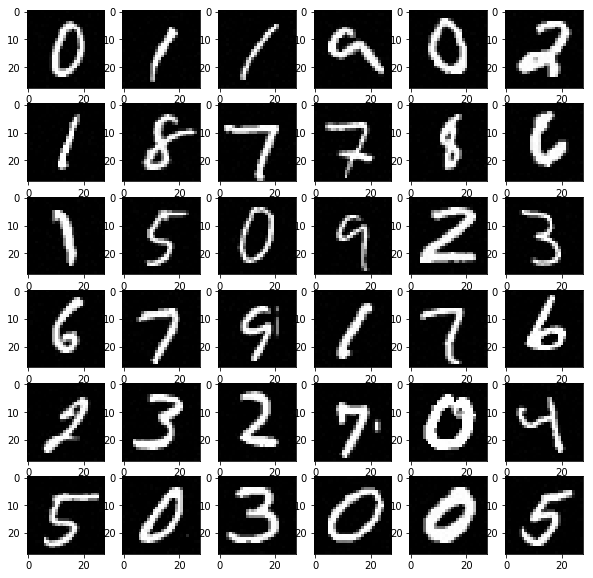

In [107]:
# Visualize the first image from the training dataset
written_train_graph = np.reshape(written_train_input, (written_train_input.shape[0], 28,28))

# first 36 written files
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6, i+1)
    plt.grid(False)
    plt.imshow(written_train_graph[i], cmap=plt.cm.binary)

Important note; there seem to be artifacts in some images. Find means to eliminate these? Not implemented yet

# 1.3 Preprocessing data

Preprocess written dataset / i.e. pixels:

In [77]:
#preprocess and apply standardscaler to the 'written' dataset. Scales according to z-values/bell-curve. 
def written_preprocess(written_data):
    #transform/rescale pixels from range 0-255 to a range between 0-1.
    written_train = written_data/255.0
    written_train[written_train>0.95] = 1
    written_train[written_train<0.05] = 0
    
    #apply standardscaler
    #sc_w = StandardScaler()
    #written_train = sc_w.fit_transform(written_data)
    return written_train

written_train = written_preprocess(written_train_input)

Preprocess spoken dataset / i.e. soundfiles. Contains padding and extends soundfiles to perform a CNN model on them. The aim is to treat the sound as an 13-color channel image:

In [78]:
def spoken_preprocess(spoken_data):
    #to be able to analyse the 45000 soundfiles, they all have to be equally long in size for any ML model to work.
    #PADDING:
    
    #pad 0's to all length arrays which are shorter than the longest array
    create_same_lengths = True
    
    if create_same_lengths:
        lengths_spoken = np.empty(len(spoken_data))
        for index, value in enumerate(spoken_data):
            lengths_spoken[index] = value.shape[0]
        
        sorted_lengths = np.sort(lengths_spoken)
        longest_length = sorted_lengths[-1]
        
        padden_spoken = []
        
        # Fill the empty array created above
        N = longest_length
        for sound in spoken_train_input:
    
            if sound.shape[0] < N:
                pad_size = N - sound.shape[0]
                length = sound.shape[1]
                
                pad_array = np.zeros((13,), dtype=np.int)
                x = np.tile(pad_array, (int(pad_size),1))
                sound = np.concatenate((sound, x), axis=0)
                padden_spoken.append(sound)
            else:
                padden_spoken.append(sound)
    
    
    #transform the list of all padded arrays to a numpy array and reshape to flat arrays            
    spoken_train_feat = np.array(padden_spoken).reshape(spoken_train_input.shape[0],int(N),13)
    
    ######### --------------------  EXPERIMENTAL PART ------------------------ ##########
    # deletes one or more of the channels.
    
    #spoken_train_feat = spoken_train_feat[:][:][:12]
    b = np.zeros((spoken_train_feat.shape[0],100,spoken_train_feat.shape[2]))
    b[:,:-7] = spoken_train_feat
    spoken_train_feat = b
    
    del b
    ######### --------------------  EXPERIMENTAL PART ------------------------ ##########
    
    spoken_train = spoken_train_feat.reshape(spoken_train_feat.shape[0],spoken_train_feat.shape[1]\
                                           * spoken_train_feat.shape[2])
    
    from sklearn.preprocessing import MinMaxScaler
    sc_s = StandardScaler(with_mean=False)
    
    spoken_scaled = sc_s.fit_transform(spoken_train)
    spoken_train_feat_image = np.reshape(spoken_scaled, (spoken_scaled.shape[0],100,13))

    return spoken_train_feat_image


In [79]:
spoken_train_feat_image = spoken_preprocess(spoken_train_input)

# The graph below is to help identify patterns in sound to check the behaviour of channels

In [101]:
#from matplotlib import cm
#
#mfcc_feat = spoken_train_feat_image[25]
#
#ig, ax = plt.subplots()
#mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
#cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
#ax.set_title('MFCC')
##Showing mfcc_data
#plt.show()
##Showing mfcc_feat
#plt.plot(mfcc_feat)
#plt.show()
#
#print(spoken_train_feat_image[25][20])

In [81]:
print(spoken_train_feat_image.shape)

(45000, 100, 13)


In [82]:
spoken_train_feat_image = np.reshape(spoken_train_feat_image, (45000,10,10,13))

In [83]:
#concatenate numpy arrays which are both rescaled
#features = np.concatenate([spoken_train1,
#                           written_train], axis = 1)

In [84]:
#create pandas dataframe for visualisation of concatenated arrays
#index = range(0, len(features))
#columns = range(0,features.shape[1])
#
#nn = pd.DataFrame(data = features, index=range(0,features.shape[0]), columns=range(0,features.shape[1]))
#nn.head()

In [85]:
#get values of the arrays to be used in the model
#X = nn.values
#y = match_train_input
#

In [86]:
#print(X.shape)
#
##X[X>2.8] = 2.8
##X[X<-2.8] = -2.8
#
#print(X[4][5])
#

# 2.1 Initialize ML / NN model

For this project we'll be using a two-branch neural network. One branch for image-feature focused ML, and the other branch for sound-feature focused ML.

CNN's are the most effective models for image analysis, especially for the MNIST Digit classification purposes.
My idea is to treat the soundfiles as images as well. So we'll be applying a CNN model on the soundfiles too. The appropriate preprocessing has been done to facilitate this step.

The final step is to join all nodes from both branches to eachother to get the necessary True/False predictions.

In [87]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
 


# 2.1.1 Sound Trainer Function

In [108]:
# Create cnn to analyze soundfiles.
def create_mlp(width, height, depth, filters=(16, 32, 64)):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    
    # define the model input
    inputs = Input(shape=inputShape)
    
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
    
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then the layers: FC => RELU => BN => DROPOUT
    # FC has 1300 nodes; 1 for soundframe
    x = Flatten()(x)
    x = Dense(1300)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the other ML model
    x = Dense(512)(x)
    x = Activation("relu")(x)
    
    # construct the CNN
    model = Model(inputs, x)
    
    # return the CNN
    return model



# 2.1.2 Image Trainer Function

In [89]:
# Create cnn to analyze images
def create_cnn(width, height, depth, filters=(16, 32, 64)):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    
    # define the model input
    inputs = Input(shape=inputShape)
    
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
    
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    # FC has 784 nodes; 1 for each pixel. 
    x = Flatten()(x)
    x = Dense(784)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the other ML model
    x = Dense(512)(x)
    x = Activation("relu")(x)
    
    # construct the CNN
    model = Model(inputs, x)
    
    # return the CNN
    return model

In [90]:
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.layers import concatenate
import numpy as np

In [91]:
# Check the shapes of the data
print(spoken_train_feat_image.shape)
print(written_train.shape)

(45000, 10, 10, 13)
(45000, 784)


# 2.1.3 Split training data into training + val

I used a simple split here by just using the first 30000 datapoints of each dataset (written, spoken, match) as training data and the last 15000 datapoints as test data:

In [92]:
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

spoken_train_feat_image1 = np.reshape(spoken_train_feat_image, (45000,10,10,13))
written_train1 = np.reshape(written_train, (written_train.shape[0], 28,28,1))


trainAttrX = spoken_train_feat_image1[:30000]
valAttrX = spoken_train_feat_image1[30000:]
trainImagesX = written_train1[:30000]
valImagesX = written_train1[30000:]

    
#Split target into training and validation data
trainY = match_train_input[:30000]
valY = match_train_input[30000:]


# 2.2 Join CNN functions and output

In [93]:
# create the MLP and CNN models
mlp = create_mlp(10, 10, 13)
cnn = create_cnn(28, 28, 1)
 
# create the input to our final set of layers as the output of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
 
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(100, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)
 
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# 2.3 Compile and Fit model with Kfold-crossvalidation 

The Kfold is optional. I need to test performance with and without Kfolds and set them out against eachother in charts to compare. One of the next steps is to automate the script to check whether kfold has any added value compared to just simply splitting the data.

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [95]:
#prepare cross validation
repeatKfold = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=2)

# two optimizers to try
opt = Adam(lr=1e-3, decay=1e-3 / 200)
optimizer = Adamax(lr=0.002,
                 beta_1=0.9, beta_2=0.999)

# Compile final ML model
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# train model by means of repeated Kfold
for train_index, test_index in repeatKfold.split(trainAttrX, trainY):
    trainAttrX9000, testAttrX9000 = trainAttrX[train_index], trainAttrX[test_index]
    trainImagesX9000, testImagesX9000 = trainImagesX[train_index], trainImagesX[test_index]
    y_train, y_val = trainY[train_index], trainY[test_index]
    print(trainAttrX9000.shape, trainImagesX9000.shape, y_train.shape, y_val.shape)
    
    # train model
    model.fit(
        [trainAttrX9000, trainImagesX9000], y_train,
        validation_data=([testAttrX9000, testImagesX9000], y_val),
        epochs=3, batch_size=100)

(22499, 10, 10, 13) (22499, 28, 28, 1) (22499,) (7501,)
Train on 22499 samples, validate on 7501 samples
Epoch 1/3
22499/22499 [==============================] - 41s 2ms/step - loss: 0.3366 - acc: 0.8971 - val_loss: 0.2660 - val_acc: 0.9055
Epoch 2/3
22499/22499 [==============================] - 28s 1ms/step - loss: 0.2268 - acc: 0.9115 - val_loss: 0.1850 - val_acc: 0.9249
Epoch 3/3
22499/22499 [==============================] - 28s 1ms/step - loss: 0.1474 - acc: 0.9365 - val_loss: 0.1255 - val_acc: 0.9504
(22500, 10, 10, 13) (22500, 28, 28, 1) (22500,) (7500,)
Train on 22500 samples, validate on 7500 samples
Epoch 1/3
22500/22500 [==============================] - 28s 1ms/step - loss: 0.0907 - acc: 0.9657 - val_loss: 0.0617 - val_acc: 0.9772
Epoch 2/3
22500/22500 [==============================] - 28s 1ms/step - loss: 0.0457 - acc: 0.9846 - val_loss: 0.0414 - val_acc: 0.9851
Epoch 3/3
22500/22500 [==============================] - 28s 1ms/step - loss: 0.0279 - acc: 0.9908 - val_loss:

# 2.4 Sanity Check, Predictions on validation set

In [98]:
y_pred = model.predict([valAttrX, valImagesX])
y_predict = (y_pred > 0.5)

Simple confusion matrix:

In [99]:
# Simple confusion matrix

# TN, FP
# FN, TP

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valY, y_predict)
correctpercentage = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print('confusion matrix:\n', cm)
print('\npercentage correctly predicted inside partitioned training set:\n' + str(correctpercentage*100) + '%')

confusion matrix:
 [[13417    59]
 [   79  1445]]

percentage correctly predicted inside partitioned training set:
99.08%


# Predict final dataset of challenge

Load testing files:

In [55]:
written_test_input = np.load("written_test.npy", allow_pickle=True)
spoken_test_input = np.load("spoken_test.npy", allow_pickle=True)

In [56]:
#apply standardscaler to the 'written' dataset, reshape to 4D for CNN
written_test = written_preprocess(written_test_input)
written_test = np.reshape(written_test, (written_test.shape[0], 28,28,1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [57]:
#apply padding and standardscaler to the 'spoken' dataset, reshape to 4D for CNN
spoken_test = spoken_preprocess(spoken_test_input)
spoken_test = np.reshape(spoken_test, (45000,10,10,13))

In [58]:
# Shape check. Each variable must be a 4D numpy array to make the joined CNN's work. 
print(written_test.shape)
print(spoken_test.shape)

(45000, 28, 28, 1)
(45000, 10, 10, 13)


In [59]:
#concatenate numpy arrays which are both rescaled
test_features = [spoken_test, written_test]

In [62]:
#predict the outcome for the final testset of the challenge
y_test = model.predict(test_features)
y_test_pred = (y_test > 0.5)

total_trues = 0
for i in y_test_pred:
    if i == True:
        total_trues+=1
print(total_trues)

estimated labeled positive: 10.017777777777779%


In [64]:
print('estimated labeled positive in final test set: '  + str((total_trues/y_test_pred.shape[0])*100) + '%')

estimated labeled positive in final test set: 10.017777777777779%


In [ ]:
#flatten result and print to numpy array for handing
result = y_test_pred.flatten()
np.save("result.npy",result)